In [4]:
# Librerías necesarias
#!pip install xgboost
#!pip install shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from scipy import stats

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Leemos los datos desde el nuevo archivo CSV
filename = 'RS_13_15_final_dataset_AVG.csv'  # Este es el nuevo archivo generado

# Definimos los nombres de las columnas según las cabeceras nuevas
nombres = [
   
    'NS_AS1_avg',  
    'NS_AS2_avg', 
    'NS_AS3_avg', 
    'NS_F1_avg', 
    'NS_F2_avg',
    'NS_F3_avg', 
    'NS_E_avg', 
    'EW_AS1_avg', 
    'EW_AS2_avg', 
    'EW_AS3_avg', 
    'EW_F1_avg', 
    'EW_F2_avg', 
    'EW_F3_avg', 
    'EW_E_avg', 
    'K_avg' ] # Etiqueta/target


# Cargamos el archivo CSV en un DataFrame
DATA = pd.read_csv(filename, names=nombres, header=0)
pd.set_option('display.max_columns', None)

# Mostramos el tamaño del dataset y un resumen rápido
print(f"Datos cargados correctamente. Tamaño: {DATA.shape}")
print(DATA.head())  # Imprime las primeras 5 filas para verificar los datos

# Separación de las características (X) y la etiqueta objetivo (y)
X = DATA.drop('K_avg', axis=1)  # Las características son todas las columnas excepto la etiqueta (K_avg)
y = DATA['K_avg']  # La etiqueta objetivo es la última columna K_avg

# Dividimos los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostramos el tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Datos cargados correctamente. Tamaño: (365, 15)
   NS_AS1_avg  NS_AS2_avg  NS_AS3_avg  NS_F1_avg  NS_F2_avg  NS_F3_avg  \
0    0.382473    0.280533    0.277095   7.831410  14.145274  20.648228   
1    0.398728    0.286725    0.274105   7.833635  14.270897  20.477838   
2    0.405653    0.295767    0.287091   7.774799  14.242236  20.489407   
3    0.373040    0.298564    0.286934   7.702141  14.144181  20.775133   
4    0.366670    0.290928    0.280243   7.731804  14.180970  20.618972   

   NS_E_avg  EW_AS1_avg  EW_AS2_avg  EW_AS3_avg  EW_F1_avg  EW_F2_avg  \
0  0.984126    0.279278    0.271557    0.262043   7.603861  13.962667   
1  0.968326    0.270303    0.270582    0.265970   7.576281  13.962911   
2  1.067938    0.297832    0.270281    0.254233   7.649983  14.109723   
3  1.038548    0.290051    0.302756    0.291753   7.551389  14.029450   
4  0.949963    0.286243    0.318797    0.318451   7.510949  13.976704   

   EW_F3_avg  EW_E_avg  K_avg  
0  20.526839  0.762515  1.125  
1  2

In [6]:
# Definición del modelo SVR
# Estandarización de los datos (es recomendable para SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo SVR
svr_model = SVR(kernel='rbf')  # Puedes cambiar el kernel (rbf, linear, poly) según sea necesario
# Aplicar cross-validation con 5 folds
scores_mse = cross_val_score(svr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(svr_model, X_train_scaled, y_train, cv=5, scoring='r2')
# Calcular la media de las métricas
mean_mse = -scores_mse.mean()  # Cross-validated MSE
mean_r2 = scores_r2.mean()  # Cross-validated R²

# Imprimir las métricas obtenidas de cross-validation
print(f"SVR (Support Vector Regressor) con cross-validation (5 folds):")
print(f"MSE promedio (cross-validation): {mean_mse}")
print(f"R² promedio (cross-validation): {mean_r2}")
# Entrenar el modelo
svr_model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = svr_model.predict(X_test_scaled)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"SVR (Support Vector Regressor):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

SVR (Support Vector Regressor) con cross-validation (5 folds):
MSE promedio (cross-validation): 0.5822413220663274
R² promedio (cross-validation): 0.3004096204938258
SVR (Support Vector Regressor):
MSE: 0.4303121806954921
MAE: 0.49108912165835017
R²: 0.497832190152122


In [7]:
## Definir el modelo XGBoost Regressor
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

# Aplicar cross-validation con 5 folds
scores_mse = cross_val_score(xgboost_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(xgboost_model, X_train, y_train, cv=5, scoring='r2')

# Calcular la media de las métricas
mean_mse = -scores_mse.mean()  # Cross-validated MSE
mean_r2 = scores_r2.mean()  # Cross-validated R²

# Imprimir las métricas obtenidas de cross-validation
print(f"XGBoost Regressor con cross-validation (5 folds):")
print(f"MSE promedio (cross-validation): {mean_mse}")
print(f"R² promedio (cross-validation): {mean_r2}")

# Entrenar el modelo con los datos de entrenamiento
xgboost_model.fit(X_train, y_train)

# Realizar predicciones con los datos de prueba
y_pred = xgboost_model.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"XGBoost Regressor:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

XGBoost Regressor con cross-validation (5 folds):
MSE promedio (cross-validation): 0.49688647743299963
R² promedio (cross-validation): 0.3982594851727716
XGBoost Regressor:
MSE: 0.4481023917773288
MAE: 0.5107373060428932
R²: 0.4770712827540131


Random Forest Regressor con cross-validation (5 folds):
MSE promedio (cross-validation): 0.5324446169335936
R² promedio (cross-validation): 0.35651501790651635
Random Forest Regressor:
MSE: 0.4101102224329715
MAE: 0.49728955752702714
R²: 0.5214075700517375


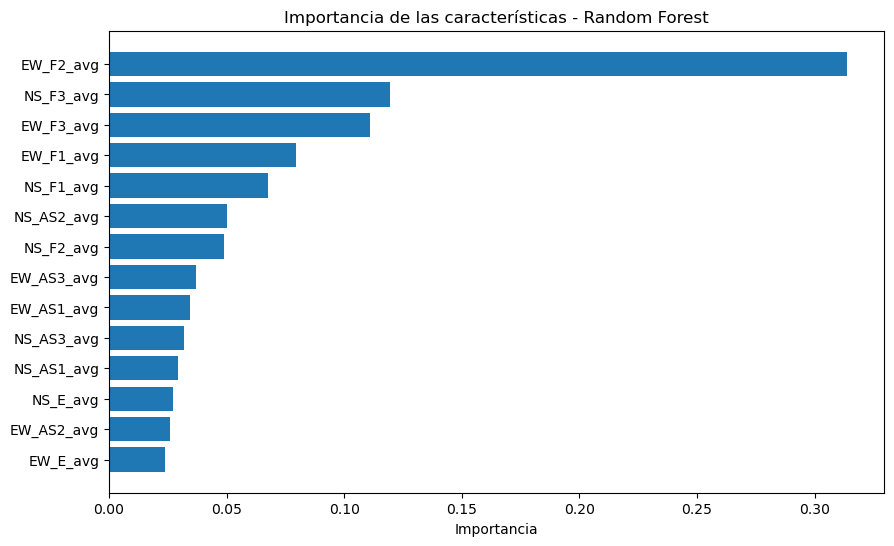

In [8]:
# Definir el modelo Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)

# Aplicar cross-validation con 5 folds
scores_mse = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

# Calcular la media de las métricas
mean_mse = -scores_mse.mean()  # Cross-validated MSE
mean_r2 = scores_r2.mean()  # Cross-validated R²

# Imprimir las métricas obtenidas de cross-validation
print(f"Random Forest Regressor con cross-validation (5 folds):")
print(f"MSE promedio (cross-validation): {mean_mse}")
print(f"R² promedio (cross-validation): {mean_r2}")

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Realizar predicciones con los datos de prueba
y_pred = rf_model.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"Random Forest Regressor:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Obtener la importancia de las características
importances = rf_model.feature_importances_

# Crear un DataFrame con los nombres de las características y sus importancias
feature_importance_df = pd.DataFrame({
    'Característica': X_train.columns,  # Asegúrate de que 'X_train.columns' contenga los nombres de las columnas
    'Importancia': importances
})

# Ordenar las características por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'])
plt.xlabel("Importancia")
plt.title("Importancia de las características - Random Forest")
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes estén en la parte superior
plt.show()

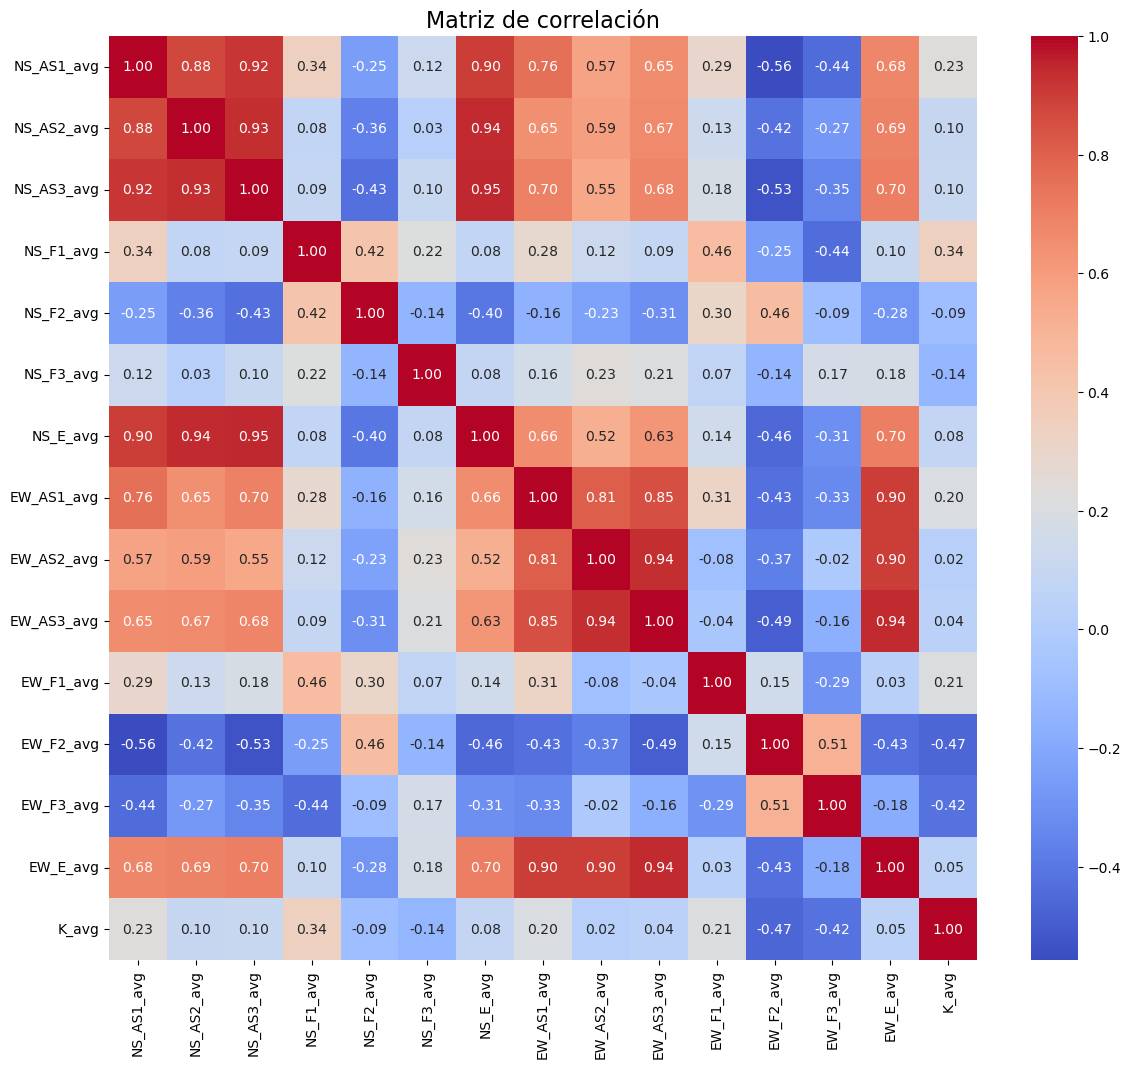

In [9]:
# Crear un dataframe con los datos de entrenamiento (X_train) y la etiqueta (y_train)
df = pd.DataFrame(X_train, columns=nombres[:-1])  # Usamos los nombres de las columnas menos la etiqueta (K_avg)
df["K_avg"] = y_train  # Añadimos la columna de la etiqueta

# Matriz de correlación
corr_matrix = df.corr()

# Graficar la matriz de correlación con un tamaño más grande
plt.figure(figsize=(14, 12))  # Aumenta el tamaño de la figura
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})  # Ajusta el tamaño del texto
plt.title("Matriz de correlación", fontsize=16)

# Guardar la imagen en el notebook
plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')  # Guardar con alta resolución
plt.show()